In [1]:
#import libraries

import numpy as np
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
from pandas import read_csv
from random import random

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
#from sklearn.inspection import permutation_importance, partial_dependence - ONLY AVAIL IN LATER VER
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The pandas version is 1.2.0.
The scikit-learn version is 0.24.0.


## Methodology

### Objective
**Use FAERS data on drug safety to identify possible risk factors associated with patient mortality and other serious adverse events associated with approved used of a drug or drug class** 

### Data
**_Outcome table_** 
1. Start with outcome_c table to define unit of analysis (primaryid)
2. Reshape outcome_c to one row per primaryid
3. Outcomes grouped into 3 categories: a. death, b. serious, c. other  
4. Multiclass model target format: each outcome grp coded into separate columns

**_Demo table_**
1. Drop fields not used in model input to reduce table size (preferably before import to notebook)
2. Check if demo table one row per primaryid (if NOT then need to reshape / clean - TBD)

**_Model input and targets_**
1. Merge clean demo table with reshaped multilabel outcome targets (rows: primaryid, cols: outcome grps)
2. Inspect merged file to check for anomalies (outliers, bad data, ...)

### Model
**_Multilabel Classifier_**
1. Since each primaryid has multiple outcomes coded in the outcome_c table, the ML model should predict the probability of each possible outcome.
2. In scikit-learn lib most/all classifiers can predict multilabel outcomes by coding target outputs into array

### Results
TBD

### Insights
TBD

## Data Pipeline: Outcome Table 

In [2]:
# read outcome_c.csv & drop unnecessary fields
infile = '../input/Outc20Q1.csv'
cols_in = ['primaryid','outc_cod']
df = pd.read_csv(infile, usecols=cols_in)
print(df.head(),'\n')
print(f'Total number of rows: {len(df):,}\n')
print(f'Unique number of primaryids: {df.primaryid.nunique():,}')

   primaryid outc_cod
0  100046942       OT
1  100048206       HO
2  100048206       OT
3  100048622       OT
4  100051352       OT 

Total number of rows: 335,470

Unique number of primaryids: 260,715


In [3]:
# distribution of outcomes
from collections import Counter
o_cnt = Counter(df['outc_cod'])
print('Distribution of Adverse Event Outcomes in FAERS 2020 Q1')
for k, v in o_cnt.items():
    print(f'{k}: {v:>8,}')

print(72*'-')
print(f'Most common outcome is {o_cnt.most_common(1)[0][0]} with {o_cnt.most_common(1)[0][1]:,} in 2020Q1')

Distribution of Adverse Event Outcomes in FAERS 2020 Q1
OT:  168,410
HO:  105,542
DE:   40,221
LT:   12,416
DS:    6,925
CA:    1,598
RI:      358
------------------------------------------------------------------------
Most common outcome is OT with 168,410 in 2020Q1


Distribution of AE Outcomes
OT    0.502012
HO    0.314609
DE    0.119894
LT    0.037011
DS    0.020643
CA    0.004763
RI    0.001067
Name: outc_cod, dtype: float64 

AxesSubplot(0.260833,0.125;0.503333x0.755)
OT    0.502012
HO    0.314609
DE    0.119894
LT    0.037011
DS    0.020643
CA    0.004763
RI    0.001067
Name: outc_cod, dtype: float64 



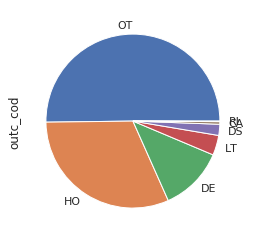

In [5]:
# DO NOT GROUP OUTCOMES FOR MULTILABEL - MUST BE 0 (-1) OR 1 FOR EACH CLASS

### create outcome groups: death:'DE', serious: ['LT','HO','DS','CA',RI], other: 'OT'

# - USE TO CREATE OUTCOME GROUPS: key(original code) : value(new code)
# map grp dict to outc_cod 

'''
outc_to_grp = {'DE':'death',
               'LT':'serious',
               'HO':'serious',
               'DS':'serious',
               'CA':'serious',
               'RI':'serious',
               'OT':'other'}
df['oc_cat'] = df['outc_cod'].map(outc_to_grp)
print(df.head(),'\n')'''

print('Distribution of AE Outcomes')
print(df['outc_cod'].value_counts()/len(df['outc_cod']),'\n')
print(df['outc_cod'].value_counts().plot(kind='pie'))
# outcome grps
print(df['outc_cod'].value_counts()/len(df['outc_cod']),'\n')

In [3]:
# one-hot encoding of outcome grp

# step1: pandas automatic dummy var coding
cat_cols = ['outc_cod']  #, 'oc_cat']
df1 = pd.get_dummies(df, prefix_sep="__", columns=cat_cols)
 
print('Outcome codes and groups')
print(f'Total number of rows: {len(df1):,}')
print(f'Unique number of primaryids: {df1.primaryid.nunique():,}\n')
print(df1.columns,'\n')
print(df1.head())
print(df1.tail())

Outcome codes and groups
Total number of rows: 335,470
Unique number of primaryids: 260,715

Index(['primaryid', 'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS',
       'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

   primaryid  outc_cod__CA  outc_cod__DE  outc_cod__DS  outc_cod__HO  \
0  100046942             0             0             0             0   
1  100048206             0             0             0             1   
2  100048206             0             0             0             0   
3  100048622             0             0             0             0   
4  100051352             0             0             0             0   

   outc_cod__LT  outc_cod__OT  outc_cod__RI  
0             0             1             0  
1             0             0             0  
2             0             1             0  
3             0             1             0  
4             0             1             0  
        primaryid  outc_cod__CA  o

In [4]:
# step 2: create multilabel outcomes by primaryid with groupby

outc_lst = ['outc_cod__CA','outc_cod__DE','outc_cod__DS','outc_cod__HO','outc_cod__LT',
            'outc_cod__OT','outc_cod__RI']
#oc_lst = ['oc_cat__death','oc_cat__other','oc_cat__serious']

df2 = df1.groupby(['primaryid'])[outc_lst].sum().reset_index()   
df2['n_outc'] = df2[outc_lst].sum(axis='columns')  # cnt total outcomes by primaryid
print(df2.columns)
print('-'*72)
print('Outcome codes in Multilabel format')
print(f'Total number of rows: {len(df2):,}')
print(f'Unique number of primaryids: {df2.primaryid.nunique():,}\n')
print(df2.head())
#print(df2.tail())
print(df2[outc_lst].corr())
print(df2.describe().T,'\n')

# plot distribution of outcome groups
'''
color = {'boxes':'DarkGreen', 'whiskers':'DarkOrange', 'medians':'DarkBlue', 'caps':'Gray'}
print(df2[outc_lst].plot.bar())  #color=color, sym='r+'))'''

Index(['primaryid', 'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS',
       'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI',
       'n_outc'],
      dtype='object')
------------------------------------------------------------------------
Outcome codes in Multilabel format
Total number of rows: 260,715
Unique number of primaryids: 260,715

   primaryid  outc_cod__CA  outc_cod__DE  outc_cod__DS  outc_cod__HO  \
0   39651443             0             0             0             0   
1   39703652             0             0             0             1   
2   39928752             0             0             0             1   
3   40142274             0             0             0             0   
4   40158544             0             0             0             0   

   outc_cod__LT  outc_cod__OT  outc_cod__RI  n_outc  
0             0             1             0       1  
1             0             1             0       2  
2             0             0             0       

"\ncolor = {'boxes':'DarkGreen', 'whiskers':'DarkOrange', 'medians':'DarkBlue', 'caps':'Gray'}\nprint(df2[outc_lst].plot.bar())  #color=color, sym='r+'))"

In [9]:
# check primaryid from outcomes table with many outcomes

# print(df2[df2['n_outc'] >= 6])  
# checked in both outcomes and demo - multiple primaryids in outcome but only one primaryid in demo
# appears to be okay to use

In [32]:
# compare primaryids above in outcomes table to same in demo table

#pid_lst = [171962202,173902932,174119951,175773511,176085111]
#[print(df_demo[df_demo['primaryid'] == p]) for p in pid_lst]  # one row in demo per primaryid - looks ok to join

In [5]:
# save multilabel data to csv
df2.to_csv('../input/outc_cod-multilabel.csv')

## Data Pipeline - Demo Table

In [8]:
# step 0: read demo.csv & check fields for missing values
infile = '../input/DEMO20Q1.csv'
#%timeit df_demo = pd.read_csv(infile) # 1 loop, best of 5: 5.19 s per loop
df_demo = pd.read_csv(infile)
print(df_demo.columns,'\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo).sum()/len(df_demo))*100}')

Index(['primaryid', 'caseid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'rept_cod', 'auth_num', 'mfr_num', 'mfr_sndr',
       'lit_ref', 'age', 'age_cod', 'age_grp', 'sex', 'e_sub', 'wt', 'wt_cod',
       'rept.dt1', 'to_mfr', 'occp_cod', 'reporter_country', 'occr_country'],
      dtype='object') 

Percent missing by column:
primaryid            0.000000
caseid               0.000000
caseversion          0.000000
i_f_code             0.000000
event.dt1           50.425676
mfr_dt               5.891247
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
auth_num            94.114401
mfr_num              5.889943
mfr_sndr             0.000000
lit_ref             94.064002
age                 41.312371
age_cod             41.309547
age_grp             89.348007
sex                 10.358072
e_sub                0.000000
wt                  80.314646
wt_cod              80.314646
rept.dt1             0.047140
to_

In [6]:
# step 1: exclude fields with large percent missing on read to preserve memory

keep_cols = ['primaryid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt', 'init_fda_dt', 'fda_dt', 
             'rept_cod',  'mfr_num', 'mfr_sndr', 'age', 'age_cod', 'age_grp','sex', 'e_sub', 'wt', 'wt_cod', 
             'rept.dt1', 'occp_cod', 'reporter_country', 'occr_country']

# removed cols: ['auth_num','lit_ref','to_mfr']

infile = '../input/DEMO20Q1.csv'
#%timeit df_demo = pd.read_csv(infile, usecols=keep_cols)  # 1 loop, best of 5: 4.5 s per loop
df_demo = pd.read_csv(infile, usecols=keep_cols)
df_demo.set_index('primaryid', drop=False)
print(df_demo.head(),'\n')
print(f'Total number of rows: {len(df_demo):,}\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo).sum()/len(df_demo))*100}')

   primaryid  caseversion i_f_code   event.dt1      mfr_dt init_fda_dt  \
0  100046942            2        F         NaN  2020-01-08  2014-03-12   
1  100048206            6        F         NaN  2020-03-05  2014-03-12   
2  100048622            2        F  2005-12-30  2020-03-12  2014-03-12   
3  100051352            2        F  2006-09-22  2020-02-20  2014-03-12   
4  100051382            2        F  1999-01-01  2020-01-08  2014-03-12   

       fda_dt rept_cod                   mfr_num mfr_sndr  ...  age_cod  \
0  2020-01-10      EXP  US-PFIZER INC-2014065112   PFIZER  ...      NaN   
1  2020-03-09      EXP  US-PFIZER INC-2014029927   PFIZER  ...       YR   
2  2020-03-16      EXP  US-PFIZER INC-2014066653   PFIZER  ...       YR   
3  2020-02-24      EXP  US-PFIZER INC-2014072143   PFIZER  ...       YR   
4  2020-01-10      EXP  US-PFIZER INC-2014071938   PFIZER  ...       YR   

  age_grp sex e_sub    wt  wt_cod    rept.dt1 occp_cod reporter_country  \
0     NaN   F     Y  81.0    

In [8]:
# step 2: merge demo and multilabel outcomes on primaryid

df_demo_outc = pd.merge(df_demo, df2, on='primaryid')
print('Demo - Multilabel outcome Merge','\n')
print(df_demo_outc.head(),'\n')
print(f'Total number of rows: {len(df_demo_outc):,}\n')
print(f'Unique number of primaryids: {df_demo_outc.primaryid.nunique():,}','\n')
print(f'Percent missing by column:\n{(pd.isnull(df_demo_outc).sum()/len(df_demo_outc))*100}')

Demo - Multilabel outcome Merge 

   primaryid  caseversion i_f_code   event.dt1      mfr_dt init_fda_dt  \
0  100046942            2        F         NaN  2020-01-08  2014-03-12   
1  100048206            6        F         NaN  2020-03-05  2014-03-12   
2  100048622            2        F  2005-12-30  2020-03-12  2014-03-12   
3  100051352            2        F  2006-09-22  2020-02-20  2014-03-12   
4  100051382            2        F  1999-01-01  2020-01-08  2014-03-12   

       fda_dt rept_cod                   mfr_num mfr_sndr  ...  \
0  2020-01-10      EXP  US-PFIZER INC-2014065112   PFIZER  ...   
1  2020-03-09      EXP  US-PFIZER INC-2014029927   PFIZER  ...   
2  2020-03-16      EXP  US-PFIZER INC-2014066653   PFIZER  ...   
3  2020-02-24      EXP  US-PFIZER INC-2014072143   PFIZER  ...   
4  2020-01-10      EXP  US-PFIZER INC-2014071938   PFIZER  ...   

   reporter_country occr_country outc_cod__CA outc_cod__DE outc_cod__DS  \
0                US           US            0    

KG     65844
LBS       72
Name: wt_cod, dtype: int64
          count        mean        std   min     25%     50%     75%     max
wt_cod                                                                      
KG      65844.0   73.377305  26.078758   0.0   59.00   72.00   86.26  720.18
LBS        72.0  171.151389  60.316181  17.0  128.75  165.75  195.25  361.00
                 age        wt_lbs
count  173965.000000  65916.000000
mean      237.044055    161.779543
std      2050.336650     57.497343
min        -3.000000      0.000000
25%        43.000000    130.072757
50%        60.000000    158.732856
75%        72.000000    190.170780
max     41879.000000   1587.725392
             age    wt_lbs
age     1.000000  0.042254
wt_lbs  0.042254  1.000000
AxesSubplot(0.125,0.125;0.775x0.755)


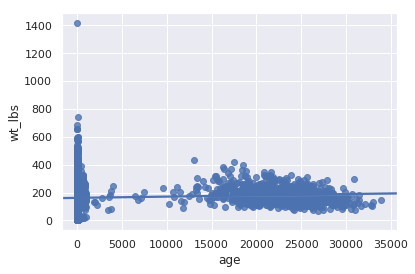

In [9]:
# step 3: calculate wt_lbs and check

print(df_demo_outc.wt_cod.value_counts()) 
print(df_demo_outc.groupby('wt_cod')['wt'].describe())
# convert kg to lbs
df_demo_outc['wt_lbs'] = np.where(df_demo_outc['wt_cod']=='KG',df_demo_outc['wt']*2.204623,df_demo_outc['wt'])
print(df_demo_outc[['age','wt_lbs']].describe())
print(df_demo_outc[['age','wt_lbs']].corr())
print(sns.regplot('age','wt_lbs',data=df_demo_outc))

### Insight: No correlation between wt and age + age range looks wrong. Check age distributions

In [14]:
# step 4: check age fields

# age_grp
print('age_grp')
print(df_demo_outc.age_grp.value_counts(),'\n') 
# age_cod
print('age_cod')
print(df_demo_outc.age_cod.value_counts(),'\n')
# age
print('age')
print(df_demo_outc.groupby(['age_grp','age_cod'])['age'].describe()) 

age_grp
A    17048
E     8674
N     1004
C      626
T      503
I      344
Name: age_grp, dtype: int64 

age_cod
YR     168732
DY       2289
MON      1434
DEC      1377
WK        134
HR         11
Name: age_cod, dtype: int64 

age
                   count       mean        std   min    25%   50%    75%  \
age_grp age_cod                                                            
A       DEC         73.0   4.424658   1.311464   2.0   3.00   5.0   6.00   
        MON          1.0  19.000000        NaN  19.0  19.00  19.0  19.00   
        YR       10548.0  46.204115  12.832555  14.0  36.00  49.0  57.00   
C       MON          4.0  29.500000   5.196152  24.0  26.25  29.0  32.25   
        YR         315.0   6.726984   3.043486   2.0   4.00   7.0   9.00   
E       DEC         65.0   7.830769   0.893890   7.0   7.00   8.0   8.00   
        YR        6096.0  74.605315   7.153633  44.0  69.00  73.0  79.00   
I       DY           1.0   1.000000        NaN   1.0   1.00   1.0   1.00   
        MO

### age_grp, age_cod, age: Distributions by age group & code look reasonable. Create age in yrs. 

age_grp
* N - Neonate
* I - Infant
* C - Child
* T - Adolescent (teen?)
* A - Adult
* E - Elderly

age_cod
* DEC - decade (yrs = 10*DEC)
* YR - year (yrs = 1*YR)
* MON - month (yrs = MON/12)
* WK - week (yrs = WK/52)
* DY - day (yrs = DY/365.25)
* HR - hour (yrs = HR/(365.25*24)) or code to zero

age_yrs
                   count       mean        std        min        25%  \
age_grp age_cod                                                        
A       DEC         73.0  44.246575  13.114645  20.000000  30.000000   
        MON          1.0   1.583333        NaN   1.583333   1.583333   
        YR       10548.0  46.204115  12.832555  14.000000  36.000000   
C       MON          4.0   2.458333   0.433013   2.000000   2.187500   
        YR         315.0   6.726984   3.043486   2.000000   4.000000   
E       DEC         65.0  78.307692   8.938895  70.000000  70.000000   
        YR        6096.0  74.605315   7.153633  44.000000  69.000000   
I       DY           1.0   0.002738        NaN   0.002738   0.002738   
        MON         63.0   0.765873   0.461283   0.083333   0.416667   
        WK           4.0   0.274038   0.282797   0.076923   0.120192   
        YR          12.0   1.166667   0.389249   1.000000   1.000000   
N       DY          61.0   0.004219   0.009373   0.00000

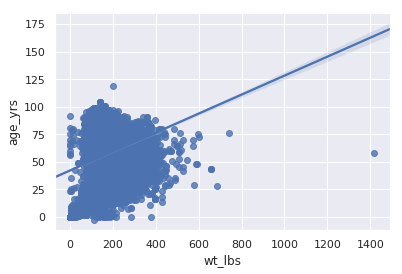

In [10]:
# step 5: calculate age_yrs and check corr with wt_lbs

df_demo_outc['age_yrs'] = np.where(df_demo_outc['age_cod']=='DEC',df_demo_outc['age']*10,
                                  np.where(df_demo_outc['age_cod']=='MON',df_demo_outc['age']/12,
                                  np.where(df_demo_outc['age_cod']=='WK',df_demo_outc['age']/52,
                                  np.where(df_demo_outc['age_cod']=='DY',df_demo_outc['age']/365.25,
                                  np.where(df_demo_outc['age_cod']=='DEC',df_demo_outc['age']/8766,
                                  df_demo_outc['age'])))))

# age_yrs
print('age_yrs')
print(df_demo_outc.groupby(['age_grp','age_cod'])['age_yrs'].describe()) 
print(df_demo_outc[['age','age_yrs']].describe())
print(df_demo_outc[['wt_lbs','age_yrs']].corr())
print(sns.regplot('wt_lbs','age_yrs',data=df_demo_outc))

### Halis checked and wt in 400-800 range (and max wt of 1,400 lbs) is correct

In [26]:
# review data where wt_lbs > 800 lbs?
print(df_demo_outc[df_demo_outc['wt_lbs'] > 800])

        primaryid  caseversion i_f_code   event.dt1      mfr_dt init_fda_dt  \
39797   169193346            6        F  2019-09-24  2020-01-16  2019-10-15   
121172  173344201            1        I         NaN  2020-01-15  2020-01-28   

            fda_dt rept_cod                                          mfr_num  \
39797   2020-01-16      EXP  JP-BRISTOL-MYERS SQUIBB COMPANY-BMS-2019-097328   
121172  2020-01-28      EXP         US-LUPIN PHARMACEUTICALS INC.-2020-00387   

                    mfr_sndr   ...      rept.dt1 occp_cod reporter_country  \
39797   BRISTOL MYERS SQUIBB   ...    2020-01-16       MD               JP   
121172                 LUPIN   ...    2020-01-28       HP               US   

       occr_country death  other serious n_outc       wt_lbs age_yrs  
39797            JP     1      1       2      4  1418.674901    58.0  
121172           US     1      1       2      4  1587.725392     NaN  

[2 rows x 27 columns]


In [16]:
# step 6: Number of AE's reported in 2020Q1 by manufacturer

print('Number of patients with adverse events by manufacturer reported in 2020Q1 from DEMO table:')
print(df_demo_outc.mfr_sndr.value_counts())  

Number of patients with adverse events by manufacturer reported in 2020Q1 from DEMO table:
PFIZER                               35415
NOVARTIS                             35022
FDA-CTU                              27113
GALDERMA                             26005
ABBVIE                               23892
JOHNSON AND JOHNSON                  21011
CELGENE                              16846
ROCHE                                16543
MYLAN                                14987
SANOFI AVENTIS                       14526
AMGEN                                13995
BRISTOL MYERS SQUIBB                 13050
TEVA                                 12774
GLAXOSMITHKLINE                      10212
ASTRAZENECA                           9396
ELI LILLY AND CO                      8441
BAYER                                 7870
ALLERGAN                              7727
AUROBINDO                             7699
MERCK                                 6750
BIOGEN                                6432
TAKEDA

In [11]:
# step 7: save updated file to csv

print(df_demo_outc.columns)
# save merged demo & multilabel data to csv
df_demo_outc.to_csv('../input/demo-outc_cod-multilabel-wt_lbs-age_yrs.csv')

Index(['primaryid', 'caseversion', 'i_f_code', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'rept_cod', 'mfr_num', 'mfr_sndr', 'age',
       'age_cod', 'age_grp', 'sex', 'e_sub', 'wt', 'wt_cod', 'rept.dt1',
       'occp_cod', 'reporter_country', 'occr_country', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs'],
      dtype='object')


## ML Pipeline: Preprocessing

In [12]:
# step 0: check cat vars for one-hot coding

cat_lst = ['i_f_code','rept_cod','sex','occp_cod']
[print(df_demo_outc[x].value_counts(),'\n') for x in cat_lst]
print(df_demo_outc[cat_lst].describe(),'\n')  # sex, occp_cod have missing values

I    164918
F     95797
Name: i_f_code, dtype: int64 

EXP      222818
PER       26229
DIR       11664
5DAY          3
30DAY         1
Name: rept_cod, dtype: int64 

F      135630
M       99851
UNK        20
Name: sex, dtype: int64 

CN    88471
MD    72708
HP    70916
PH    17819
LW     3740
Name: occp_cod, dtype: int64 

       i_f_code rept_cod     sex occp_cod
count    260715   260715  235501   253654
unique        2        5       3        5
top           I      EXP       F       CN
freq     164918   222818  135630    88471 



In [13]:
# step 1: create one-hot dummies for multilabel outcomes

cat_cols = ['i_f_code', 'rept_cod', 'occp_cod', 'sex']
df = pd.get_dummies(df_demo_outc, prefix_sep="__", columns=cat_cols, drop_first=True)
print(df.columns)
print(df.describe().T)
print(df.head())

Index(['primaryid', 'caseversion', 'event.dt1', 'mfr_dt', 'init_fda_dt',
       'fda_dt', 'mfr_num', 'mfr_sndr', 'age', 'age_cod', 'age_grp', 'e_sub',
       'wt', 'wt_cod', 'rept.dt1', 'reporter_country', 'occr_country',
       'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI', 'n_outc', 'wt_lbs',
       'age_yrs', 'i_f_code__I', 'rept_cod__5DAY', 'rept_cod__DIR',
       'rept_cod__EXP', 'rept_cod__PER', 'occp_cod__HP', 'occp_cod__LW',
       'occp_cod__MD', 'occp_cod__PH', 'sex__M', 'sex__UNK'],
      dtype='object')
                   count          mean           std         min  \
primaryid       260715.0  1.905476e+08  1.567929e+08  39651443.0   
caseversion     260715.0  1.950620e+00  2.538483e+00         1.0   
age             173965.0  2.370441e+02  2.050337e+03        -3.0   
wt               65916.0  7.348410e+01  2.633834e+01         0.0   
outc_cod__CA    260715.0  6.129298e-03  7.804969e-02         0.0   

## check sklearn for imputation options

In [24]:
# step 2: use means to impute the missing values of the features with missing records

# calculate percent missing
print(df.columns,'\n')
print(f'Percent missing by column:\n{(pd.isnull(df).sum()/len(df))*100}')

num_inputs = ['n_outc', 'wt_lbs', 'age_yrs']
cat_inputs = ['n_outc', 'wt_lbs', 'age_yrs', 'i_f_code__I',  'rept_cod__5DAY', 
              'rept_cod__DIR', 'rept_cod__EXP', 'rept_cod__PER', 'occp_cod__HP', 
              'occp_cod__LW', 'occp_cod__MD', 'occp_cod__PH', 'sex__M', 'sex__UNK']

inputs = num_inputs + cat_inputs
print(inputs)

target_labels = ['oc_cat__death', 'oc_cat__other', 'oc_cat__serious']

# calculate means
means = df[inputs].mean()
print(means.shape, means)

Index(['primaryid', 'caseid', 'caseversion', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'auth_num', 'mfr_num', 'mfr_sndr', 'lit_ref',
       'age', 'age_cod', 'age_grp', 'e_sub', 'wt', 'wt_cod', 'rept.dt1',
       'to_mfr', 'reporter_country', 'occr_country', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'oc_cat__death', 'oc_cat__other',
       'oc_cat__serious', 'n_outc', 'wt_lbs', 'age_yrs', 'i_f_code__I',
       'rept_cod__5DAY', 'rept_cod__DIR', 'rept_cod__EXP', 'rept_cod__PER',
       'occp_cod__HP', 'occp_cod__LW', 'occp_cod__MD', 'occp_cod__PH',
       'sex__M', 'sex__UNK'],
      dtype='object') 

Percent missing by column:
primaryid            0.000000
caseid               0.000000
caseversion          0.000000
event.dt1           45.019657
mfr_dt               4.475769
init_fda_dt          0.000000
fda_dt               0.000000
auth_num            90.010164
mfr_num              4.47385

In [42]:
# mean fill NA
'''
wt_lbs            161.779543
age_yrs            55.906426
'''
df['wt_lbs_mean'] = np.where(pd.isnull(df['wt_lbs']),161.779543,df['wt_lbs'])  
df['age_yrs_mean'] = np.where(pd.isnull(df['age_yrs']),55.906426,df['age_yrs'])  
print('mean fill NA - wt_lbs & age_yrs')
print(df.describe().T)
print(df.columns)

mean fill NA - wt_lbs & age_yrs
                    count          mean           std         min  \
primaryid        260715.0  1.905476e+08  1.567929e+08  39651443.0   
caseid           260715.0  1.704415e+07  1.077987e+06   3965144.0   
caseversion      260715.0  1.950620e+00  2.538483e+00         1.0   
age              173965.0  2.370441e+02  2.050337e+03        -3.0   
wt                65916.0  7.348410e+01  2.633834e+01         0.0   
outc_cod__CA     260715.0  6.129298e-03  7.804969e-02         0.0   
outc_cod__DE     260715.0  1.542719e-01  3.612099e-01         0.0   
outc_cod__DS     260715.0  2.656157e-02  1.607985e-01         0.0   
outc_cod__HO     260715.0  4.048175e-01  4.908576e-01         0.0   
outc_cod__LT     260715.0  4.762288e-02  2.129674e-01         0.0   
outc_cod__OT     260715.0  6.459544e-01  4.782240e-01         0.0   
outc_cod__RI     260715.0  1.373147e-03  3.703062e-02         0.0   
oc_cat__death    260715.0  1.542719e-01  3.612099e-01         0.0   
oc

In [43]:
### standarize features 

drop_cols = ['primaryid', 'caseid', 'caseversion', 'event.dt1', 'mfr_dt',
       'init_fda_dt', 'fda_dt', 'auth_num', 'mfr_num', 'mfr_sndr', 'lit_ref',
       'age', 'age_cod', 'age_grp', 'e_sub', 'wt', 'wt_cod', 'rept.dt1',
       'to_mfr', 'reporter_country', 'occr_country', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'oc_cat__death', 'oc_cat__other',
       'oc_cat__serious', 'wt_lbs', 'age_yrs']

inputs_mean = ['n_outc', 'wt_lbs_mean', 'age_yrs_mean', 'i_f_code__I', 'rept_cod__5DAY',
               'rept_cod__DIR', 'rept_cod__EXP', 'rept_cod__PER', 'occp_cod__HP', 
               'occp_cod__LW', 'occp_cod__MD', 'occp_cod__PH', 'sex__M']

X = df.drop(columns=drop_cols)
print(X.columns)

Xscaled = StandardScaler().fit_transform(X)
print(Xscaled.shape)

#X = pd.DataFrame(scaled, columns=inputs_mean)  #.reset_index()
#print(X.describe().T,'\n')

#y_multilabel = np.c_[df['CA'], df['DE'], df['DS'], df['HO'], df['LT'], df['OT'], df['RI']]
y_multilabel = np.c_[df['oc_cat__death'], df['oc_cat__other'], df['oc_cat__serious']]
print(y_multilabel.shape)

Index(['n_outc', 'i_f_code__I', 'rept_cod__5DAY', 'rept_cod__DIR',
       'rept_cod__EXP', 'rept_cod__PER', 'occp_cod__HP', 'occp_cod__LW',
       'occp_cod__MD', 'occp_cod__PH', 'sex__M', 'sex__UNK', 'wt_lbs_mean',
       'age_yrs_mean'],
      dtype='object')
(260715, 14)
(260715, 3)


In [44]:
# test multilabel classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(Xscaled,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
knn_clf.score(Xscaled,y_multilabel)

ValueError: multiclass-multioutput is not supported

In [ ]:
# review sklean api - hamming_loss, jaccard_similarity_score, f1_score
from sklearn.metrics import hamming_loss, jaccard_similarity_score
pred_knn_multilabel = knn_clf.pred(Xscaled)
f1_score(y_multilabel, pred_knn_multilabel, average='macro')

# STOPPED HERE - 1.13.2021

## ML Pipeline: Model Selection

In [38]:
### define functions for evaluating each of 8 types of supervised learning algorithms

def evaluate_model(predictors, targets, model, param_dict, passes=500):
    
    seed = int(round(random()*1000,0))
    print(seed)
    
    # specify minimum test MSE, best hyperparameter set
    test_err = []
    min_test_err = 1e10
    best_hyperparams = {}
    # specify MSE predicted from the full dataset by the optimal model of each type with the best hyperparameter set
    #full_y_err = None
    full_err_mintesterr = None
    full_err = []
    # specify the final model returned
    ret_model = None
    
    # define MSE as the statistic to determine goodness-of-fit - the smaller the better
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # split the data to a training-testing pair randomly by passes = n times
    for i in range(passes):
        print('Pass {}/{} for model {}'.format(i + 1, passes, model))
        X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=0.3, random_state=(i+1)*seed )
        
        # 3-fold CV on a training set, and returns an optimal_model with the best_params_ fit
        default_model = model()
        model_gs = GridSearchCV(default_model, param_dict, cv=3, n_jobs=-1, verbose=0, scoring=scorer)  # n_jobs=16,
        model_gs.fit(X_train, y_train)
        optimal_model = model(**model_gs.best_params_)
        optimal_model.fit(X_train, y_train)
        
        # use the optimal_model generated above to test in the testing set and yield an MSE
        y_pred = optimal_model.predict(X_test)
        err = mean_squared_error(y_test, y_pred)
        test_err.extend([err]) 
        
        # use the optimal_model generated above to be applied to the full data set and predict y to yield an MSE
        full_y_pred=optimal_model.predict(predictors)
        full_y_err = mean_squared_error(full_y_pred, y)
        full_err.extend([full_y_err]) 
    
        # look for the smallest MSE yield from the testing set, 
        # so the optimal model that meantimes yields the smallest MSE from the testing set can be considered as the final model of the type
        #print('MSE for {}: {}'.format(model, err))
        if err < min_test_err:
            min_test_err = err
            best_hyperparams = model_gs.best_params_
            
            full_err_mintesterr = full_y_err

            # return the final model of the type
            ret_model = optimal_model
            
    test_err_dist = pd.DataFrame(test_err, columns=["test_err"]).describe()
    full_err_dist = pd.DataFrame(full_err, columns=["full_err"]).describe()
    
    print('Model {} with hyperparams {} yielded \n\ttest error {} with distribution \n{} \n\
    toverall error {} with distribution \n{}'. \
          format(model, best_hyperparams, min_test_err, test_err_dist, full_err_mintesterr,full_err_dist))
    return ret_model

In [34]:
#%lsmagic

In [39]:
# Random Forest
#%%timeit 
rf = evaluate_model(X,y, RandomForestClassifier, 
                          {'n_estimators': [200, 400, 800,1000],
                           'max_depth': [2, 3, 4, 5], 
                           'min_samples_leaf': [2,3],
                           'min_samples_split': [2, 3, 4],
                           'max_features' : ['auto', 'sqrt', 'log2']}, passes=1)  # 250)

988
Pass 1/1 for model <class 'sklearn.ensemble.forest.RandomForestClassifier'>


exception calling callback for <Future at 0xaa978ef0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/lib/python3/dist-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/usr/lib/python3/dist-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/lib/python3/dist-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/lib/python3/dist-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/lib/python3/dist-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/usr/lib/python3/dist-packages/joblib/externals/loky/reusable_execu

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGBUS(-7)}

# STOPPED HERE - 1.12.2021
## TODOs:
1. Multicore processing: Setup Dask for multicore processing in Jupyter Notebook
2. Distributed computing: Check Dask Distributed for local cluster setup

In [ ]:
from joblib import dump, load

dump(rf, 'binary_rf.obj')  # rf_model

In [ ]:
features2 = pd.DataFrame(data=rf.feature_importances_, index=data.columns)
features2.sort_values(by=0,ascending=False, inplace=True)
print(features2[:50])

In [ ]:
import seaborn as sns

ax_rf = sns.barplot(x=features2.index, y=features2.iloc[:,0], order=features2.index)
ax_rf.set_ylabel('Feature importance')
fig_rf = ax_rf.get_figure()

In [ ]:
rf_top_features=features2.index[:2].tolist()
print(rf_top_features)

In [ ]:
pdp, axes = partial_dependence(rf, X= data, features=[(0, 1)], grid_resolution=20)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
#ax.set_xlabel('% Severe Housing \nCost Burden', fontsize=12)
#ax.set_ylabel('% Veteran', fontsize=15)
ax.set_xlabel('% mortality diff', fontsize=12)
ax.set_ylabel('% severe housing \ncost burden', fontsize=15)
ax.set_zlabel('Partial dependence', fontsize=15)
ax.view_init(elev=22, azim=330)
plt.colorbar(surf)
plt.suptitle('Partial Dependence of Top 2 Features \nRandom Forest', fontsize=15)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
print(features2.index[range(14)])
datafeatures2 = pd.concat([states,y,data[features2.index[range(38)]]],axis=1)
datafeatures2.head(10)

In [ ]:
from sklearn.inspection import permutation_importance

# feature names 
feature_names = list(features2.columns)
# model - rf
model = load('binary_rf.obj')
# calculate permutation importance - all data - final model
perm_imp_all = permutation_importance(model, data, y, n_repeats=10, random_state=42)

print('Permutation Importances - mean')
print(perm_imp_all.importances_mean)



'''
# create dict of feature names and importances
fimp_dict_all = dict(zip(feature_names,perm_imp_all.importances_mean))

# feature importance - all
print('Permutation Importance for All Data')
print(fimp_dict_all)
# plot importances - all
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, fimp_dict_all.importances_mean, align='center', alpha=0.5)
plt.yticks(y_pos, feature_names)
plt.xlabel('Permutation Importance - All')
plt.title('Feature Importance - All Data')
plt.show()
'''

In [ ]:
dataused = pd.concat([states,y,data],axis=1)
print(dataused.shape)
print(dataused.head(10))

In [ ]:
#from joblib import dump, load

dump(perm_imp_all, 'perm_imp_rf.obj')

In [ ]:
dataused.to_excel(r'dataused_cj08292020_v2.xlsx',index=None, header=True)

### END BG RF ANALYSIS - 8.31.2020

### OTHER MODELS NOT RUN

In [ ]:
# LASSO     
    
lasso = evaluate_model(data, Lasso, {'alpha': np.arange(0, 1.1, 0.001), 
                                     'normalize': [True],
                                     'tol' : [1e-3, 1e-4, 1e-5],
                                     'max_iter': [1000, 4000, 7000]}, passes=250)

In [ ]:
# Ridge regression

ridge = evaluate_model(data, Ridge, {'alpha': np.arange(0, 1.1, 0.05), 
                                     'normalize': [True], 
                                     'tol' : [1e-3, 1e-4, 1e-5],
                                     'max_iter': [1000, 4000, 7000]}, passes=250)

In [ ]:
# K-nearest neighborhood

knn = evaluate_model(data, KNeighborsRegressor, {'n_neighbors': np.arange(1, 8),
                                                 'algorithm': ['ball_tree','kd_tree','brute']}, passes=250)

In [ ]:
# Gradient Boosting Machine

gbm = evaluate_model(data, GradientBoostingRegressor, {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
                                                       'n_estimators': [100, 200, 400, 800, 1000],
                                                       'min_samples_leaf': [2,3],
                                                       'max_depth': [2, 3, 4, 5],
                                                       'max_features': ['auto', 'sqrt', 'log2']}, passes=250)

In [ ]:
# CART: classification and regression tree

cart = evaluate_model(data, DecisionTreeRegressor, {'splitter': ['best', 'random'], 
                                                    'criterion': ['mse', 'friedman_mse', 'mae'],
                                                    'max_depth': [2, 3, 4, 5],
                                                    'min_samples_leaf': [2,3],
                                                    'max_features' : ['auto', 'sqrt', 'log2']}, passes=250)

In [ ]:
# Neural network: multi-layer perceptron

nnmlp = evaluate_model(data, MLPRegressor, {'hidden_layer_sizes': [(50,)*3, (50,)*5, (50,)*10, (50,)*30, (50,)*50],
                                            'activation': ['identity','logistic','tanh','relu']}, passes=250)

In [ ]:
# Support Vector Machine: a linear function is an efficient model to work with

svm = evaluate_model(data, LinearSVR, {'tol': [1e-3, 1e-4, 1e-5],
                                       'C' : np.arange(0.1,3,0.1),
                                       'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
                                       'max_iter': [1000, 2000, 4000]}, passes=250)

In [ ]:
features1 = pd.DataFrame(data=gbm.feature_importances_, index=data.columns)
features1.sort_values(by=0,ascending=False, inplace=True)
print(features1[:40])

In [ ]:
print(features1.index[range(38)])
datafeatures1 = pd.concat([states,y,data[features1.index[range(38)]]],axis=1)
datafeatures1.head(10)

In [ ]:
import seaborn as sns

ax_gbm = sns.barplot(x=features1.index, y=features1.iloc[:,0], order=features1.index)
ax_gbm.set_ylabel('Feature importance')
fig_gbm = ax_gbm.get_figure()